# Single negative muon simulation track quality

In [2]:
import uproot
import awkward as ak
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches

import vector
vector.register_awkward() #Allows Awkward array records to be interpreted as vectors

#load ROOT file
events = uproot.open('input/SimpleTree_mudst.root:data')
print(events)

#To check branches
events.keys()

<TTree 'data' (33 branches) at 0x7fc7807a5fd0>


['Cal_nhits',
 'Cal_detid',
 'Cal_hitid',
 'Cal_adcsum',
 'Cal_hit_energy',
 'Cal_hit_posx',
 'Cal_hit_posy',
 'Cal_hit_posz',
 'Trk_ntrks',
 'Trk_px',
 'Trk_py',
 'Trk_pz',
 'Trk_charge',
 'Trk_chi2',
 'Trk_ndf',
 'Trk_proj_ecal_x',
 'Trk_proj_ecal_y',
 'Trk_proj_ecal_z',
 'Trk_proj_hcal_x',
 'Trk_proj_hcal_y',
 'Trk_proj_hcal_z',
 'mcpart_num',
 'mcpart_index',
 'mcpart_geid',
 'mcpart_idVtx',
 'mcpart_px',
 'mcpart_py',
 'mcpart_pz',
 'mcpart_E',
 'mcpart_charge',
 'mcpart_Vtx_x',
 'mcpart_Vtx_y',
 'mcpart_Vtx_z']

### Generated particle information

In [20]:
mc_arrays = events.arrays(filter_name="mcpart_*")
print("")
print(mc_arrays.type)
print("")

#Select only generated muon, exclude secondaries
cut_primary = mc_arrays["mcpart_geid"]==6 #Geant3 id code

px = mc_arrays["mcpart_px"][cut_primary]
py = mc_arrays["mcpart_py"][cut_primary]
pz = mc_arrays["mcpart_pz"][cut_primary]

particles = vector.zip({
    "px": px,
    "py": py,
    "pz": pz,
})

#For testing
print(particles)
print(particles.pt)

pt = np.sqrt(px**2+py**2)
print(pt)
print(ak.count(pt,axis=-1))
print(ak.count(pt))


1000 * {"mcpart_num": int32, "mcpart_index": var * int32, "mcpart_geid": var * int32, "mcpart_idVtx": var * int32, "mcpart_px": var * float32, "mcpart_py": var * float32, "mcpart_pz": var * float32, "mcpart_E": var * float32, "mcpart_charge": var * int32, "mcpart_Vtx_x": var * float32, "mcpart_Vtx_y": var * float32, "mcpart_Vtx_z": var * float32}

[[{x: -0.547, y: -2.9, z: 29.9}], [{x: -1.68, ... [{x: -1.43, y: -2.59, z: 29.9}]]
[[2.95], [2.97], [2.97], [2.96], [2.95], ... [2.95], [2.95], [2.95], [2.97], [2.96]]
[[2.95], [2.97], [2.97], [2.96], [2.95], ... [2.95], [2.95], [2.95], [2.97], [2.96]]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1000


### Reconstructed tracks

In [64]:
trk_arrays = events.arrays(filter_name="Trk_*")
print("")
print(trk_arrays.type)
print("")

num_trk = trk_arrays["Trk_ntrks"]
rec_px = trk_arrays["Trk_px"]
rec_py = trk_arrays["Trk_py"]
rec_pz = trk_arrays["Trk_pz"]
rec_charge = trk_arrays["Trk_charge"]

rec_particles = vector.zip({
    "px": rec_px,
    "py": rec_py,
    "pz": rec_pz,
})

#For testing
print(num_trk)

print(rec_particles.pt)

rec_pt = np.sqrt(rec_px**2+rec_py**2)
print(rec_pt)
print(ak.count(rec_pt,axis=-1))
print(ak.count(rec_pt))


1000 * {"Trk_ntrks": int32, "Trk_px": var * float32, "Trk_py": var * float32, "Trk_pz": var * float32, "Trk_charge": var * int32, "Trk_chi2": var * float32, "Trk_ndf": var * float32, "Trk_proj_ecal_x": var * float32, "Trk_proj_ecal_y": var * float32, "Trk_proj_ecal_z": var * float32, "Trk_proj_hcal_x": var * float32, "Trk_proj_hcal_y": var * float32, "Trk_proj_hcal_z": var * float32}

[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ... 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[], [1.57], [1.92], [2.31], [1.8], [2.06, ... [1.98], [1.9], [2.34], [2.07], [13.1]]
[[], [1.57], [1.92], [2.31], [1.8], [2.06, ... [1.98], [1.9], [2.34], [2.07], [13.1]]
[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ... 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
922


### Make plots

[{x: 922, y: 922, z: 922}]
[{x: 922, y: 922, z: 922}]


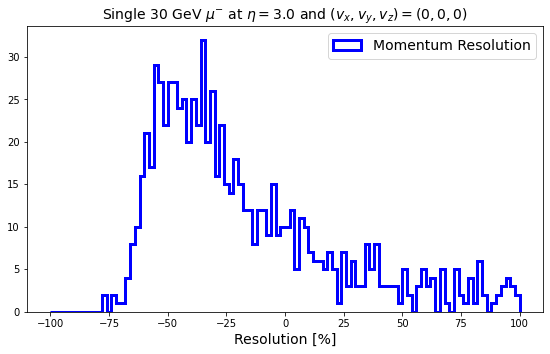

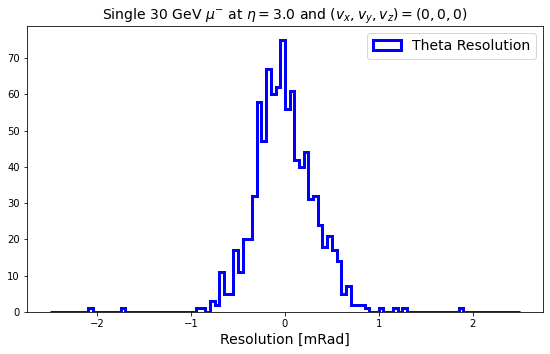

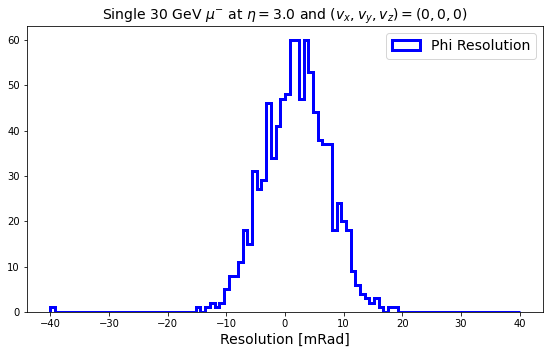

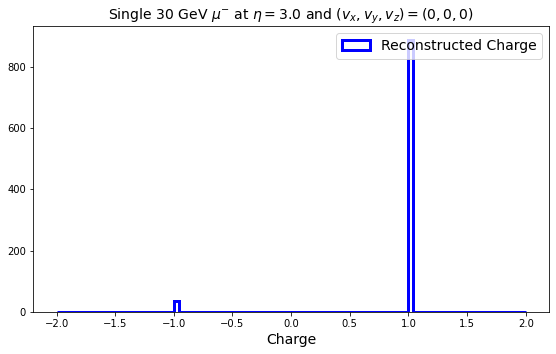

In [66]:
#For reconstruction plots, remove events with no reconstructed tracks
particles_wtrk = particles[num_trk>0]
rec_particles_wtrk = rec_particles[num_trk>0]
rec_charge_wtrk = rec_charge[num_trk>0]

#For testing
print(ak.count(particles_wtrk,axis=0))
print(ak.count(rec_particles_wtrk,axis=0))

## Plot 1 -- momentum resolution in %
mom_res = 100.*( (rec_particles_wtrk.p-particles_wtrk.p) / particles_wtrk.p)

plt.hist(mom_res,label="Momentum Resolution",histtype='step',ec='blue',
         lw=3,bins=100,range=[-100,100])
plt.xlabel("Resolution [%]",fontsize=14)
plt.title('Single 30 GeV $\mu^{-}$ at $\eta = 3.0$ and $(v_{x},v_{y},v_{z}) = (0,0,0)$',fontsize=14)
plt.legend(fontsize=14)

#Figure Output
fig = plt.gcf()
fig.set_size_inches(18.5/2, 10.5/2)
plt.show()

## Plot 2 -- Theta resolution in mRad
theta_res = 1000.* (rec_particles_wtrk.theta-particles_wtrk.theta)

plt.hist(theta_res,label="Theta Resolution",histtype='step',ec='blue',
         lw=3,bins=100,range=[-2.5,2.5])
plt.xlabel("Resolution [mRad]",fontsize=14)
plt.title('Single 30 GeV $\mu^{-}$ at $\eta = 3.0$ and $(v_{x},v_{y},v_{z}) = (0,0,0)$',fontsize=14)
plt.legend(fontsize=14)

#Figure Output
fig = plt.gcf()
fig.set_size_inches(18.5/2, 10.5/2)
plt.show()

## Plot 3 -- Phi resolution in mRad
phi_res = 1000.* (rec_particles_wtrk.phi-particles_wtrk.phi)

plt.hist(phi_res,label="Phi Resolution",histtype='step',ec='blue',
         lw=3,bins=100,range=[-40,40])
plt.xlabel("Resolution [mRad]",fontsize=14)
plt.title('Single 30 GeV $\mu^{-}$ at $\eta = 3.0$ and $(v_{x},v_{y},v_{z}) = (0,0,0)$',fontsize=14)
plt.legend(fontsize=14)

#Figure Output
fig = plt.gcf()
fig.set_size_inches(18.5/2, 10.5/2)
plt.show()

## Plot 4 -- Reconstructed charge
plt.hist(rec_charge_wtrk,label="Reconstructed Charge",histtype='step',ec='blue',
         lw=3,bins=100,range=[-2,2])
plt.xlabel("Charge",fontsize=14)
plt.title('Single 30 GeV $\mu^{-}$ at $\eta = 3.0$ and $(v_{x},v_{y},v_{z}) = (0,0,0)$',fontsize=14)
plt.legend(fontsize=14)

#Figure Output
fig = plt.gcf()
fig.set_size_inches(18.5/2, 10.5/2)
plt.show()